In [1]:
import os
import random
%load_ext autoreload
%autoreload 2
import pickle
import pandas as pd
%matplotlib inline
from matplotlib.ticker import FuncFormatter 
import matplotlib
import matplotlib.pyplot as plt
import glob
from pdb import set_trace
import json
import numpy as np
from scipy import stats

game_titles = {
        "shuffleKeys_game": "Shuffle Keys Game",
        "contingency_game": "Contingency Game",
        "contingency_game_r0": "Contingency Game (Agent Placement is Constant Among Each Level)",
        "contingency_game_shuffled": "Shuffled Keys Game (Shuffled Once in Every 200 Levels, Single Seed)",
        "logic_game": "Logic Game",
        "logic_extended_game": "Ext Logic",
    }

label_dict = { 'human': 'Human', 'self_class': 'Self Class', 'dqn_training': 'DQN',
                       'random': 'Random', 'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training':'PPO2',
               'acer_training': 'ACER'}

def ts_plotter(self, ax, data1, data2):
    '''
    Helper for plotting panels in time series plot.
    '''

    out = ax.plot(data1, data2, linewidth=2)
    return out

In [2]:
def get_performance(game_types, agent_types, y_lims, batch_size=10, single_seed=False):
    ''' Plot performance for games and agents'''
    param_dict = {}

    ## ----- Read in data
    ext_data = []
    for i, game_type in enumerate(game_types):
        param_dict[game_type] = {}
        for agent_type in agent_types:
            files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")
            if len(files) == 0:
                files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

            seed = 0
            curr_file_count = 0
            param_dict[game_type][agent_type] = {}
            seed_current = []
            all_seeds = []
            seed_total = 10 if not single_seed else 1
            for i, file in enumerate(sorted(files, key=os.path.getmtime)):
                with open(file, 'r') as fp:
                    if agent_type == 'human' and game_type == 'logic':  # TODO: change after we get data
                        f = open(file, 'rb')
                        param_dict[game_type][agent_type] = pickle.load(f)
                        continue

                    data = json.load(fp)

                    param_dict[game_type][agent_type] = data['data']['steps']
                    curr_file_count += 1

                    seed_current.append(data['data']['steps'])

                    if curr_file_count == 20:
                        all_seeds.append(seed_current)
                        seed_current = []
                        curr_file_count = 0
                        seed += 1

                    if seed == seed_total:
                        param_dict[game_type][agent_type] = all_seeds
                        all_seeds = []

                        if single_seed:
                            break

    ## ---- Get descriptive statistics
    stats_dict = {}
    for game_type in game_types:
        stats_dict[game_type] = {}
        for agent_type in agent_types:
            curr_data = pd.DataFrame(param_dict[game_type][agent_type])

            seed_average = []
            for column in curr_data:
                seed_average.append(np.mean(list(curr_data[column]), axis=0))
            # TODO
            # curr_data = pd.concat([pd.DataFrame(seed_average).T, pd.DataFrame(ext_avg).T], ignore_index=True)
            curr_data = pd.DataFrame(seed_average).T
            stats_dict[game_type][agent_type] = curr_data
            if agent_type != 'human':
                stats_dict[game_type][agent_type + "_m"] = np.array(
                    [curr_data[column].groupby(curr_data.index // batch_size).mean() for column in curr_data]).reshape(
                    int(curr_data.shape[1] * 100 * 1 / batch_size))
                stats_dict[game_type][agent_type + "_se"] = np.array(
                    [curr_data[column].groupby(curr_data.index // batch_size).sem() for column in curr_data]).reshape(
                    int(curr_data.shape[1] * 100 * 1 / batch_size))
            else:
                stats_dict[game_type][agent_type + "_m"] = np.array(
                    [curr_data[column].groupby(curr_data.index // batch_size).mean() for column in curr_data]).reshape(
                    int(100 / batch_size))
                stats_dict[game_type][agent_type + "_se"] = np.array(
                    [curr_data[column].groupby(curr_data.index // batch_size).sem() for column in curr_data]).reshape(
                    int(100 / batch_size))

    ## ---- Plot data
    return stats_dict, game_types, agent_types, y_lims, batch_size


def plotter(stats, game_types, agent_types, y_lims, batch_size, combined=False):
    for i, game_type in enumerate(game_types):
        st = stats[game_type]

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        if combined:
            y_str = "No. of Steps to Complete Level ({} Level MA) \nGame modified after 2000 Level Boundary".format(
                batch_size)
        else:
            y_str = "No. of Steps to Complete Level ({} Level MA)".format(
                batch_size)
        ax.set_ylabel(ylabel=y_str, labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)
        ax.set_title(game_titles[game_type], fontweight='bold', fontsize=15)

        colors = ["#0373fc", "#d002f5", "#000000", "#fa0047", "#ff8903", "#03fc9d"]
        for i, agent_type in enumerate(agent_types):

            if agent_type != 'human':
                xs = [int(i * batch_size) for i in range(0, len(st[agent_type + "_m"]))]
                r_l = ax.plot(xs, st[agent_type + "_m"], color=colors[i], linewidth=1, label=label_dict[agent_type])
                x = [int(i * batch_size) for i in range(0, len(st[agent_type + "_m"]))]
                ax.fill_between(x, st[agent_type + "_m"] - st[agent_type + "_se"],
                                st[agent_type + "_m"] + st[agent_type + "_se"], alpha=0.08, color=colors[i])
            else:
                xs = [int(i * batch_size) for i in range(0, len(st["human_m"]) + 1)]
                hum_l = ax.plot(xs, np.append(st['human_m'], st['human_m'][1]), color=colors[i], linewidth=2,
                                label=label_dict['human'])
                x = [int(i * batch_size) for i in range(0, len(st["human_m"]) + 1)]
                ax.fill_between(x, np.append(st['human_m'] - st['human_se'], st['human_m'][1] - st['human_se'][1]),
                                np.append(st['human_m'] + st['human_se'], st['human_m'][1] + st['human_se'][1]),
                                alpha=0.08, color=colors[i])

        # first_legend = plt.legend(handles=[r_l[0], dqn_l[0], sc_l[0], hum_l[0]], loc='upper right', prop={'size': 22})
        if combined:
            plt.axvline(x=2000, color="#ffff03", alpha=0.2, linewidth=15)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.show()
        fig.savefig('effiency_curves_' + game_type + '.pdf', format='pdf')


# Append stats of two data (normal + extended)
def append_stats(dict_normal, dict_ext, game_types, game_types_ext, agent_types):
    appended_data = {}
    for i, game in enumerate(game_types):
        appended_data[game] = {}
        for agent in agent_types:
            for key, value in dict_normal[game].items():
                data_normal = dict_normal[game][key]
                data_ext = dict_ext[game_types_ext[i]][key]
                appended_data[game][key] = np.concatenate((data_normal, data_ext))

    return appended_data

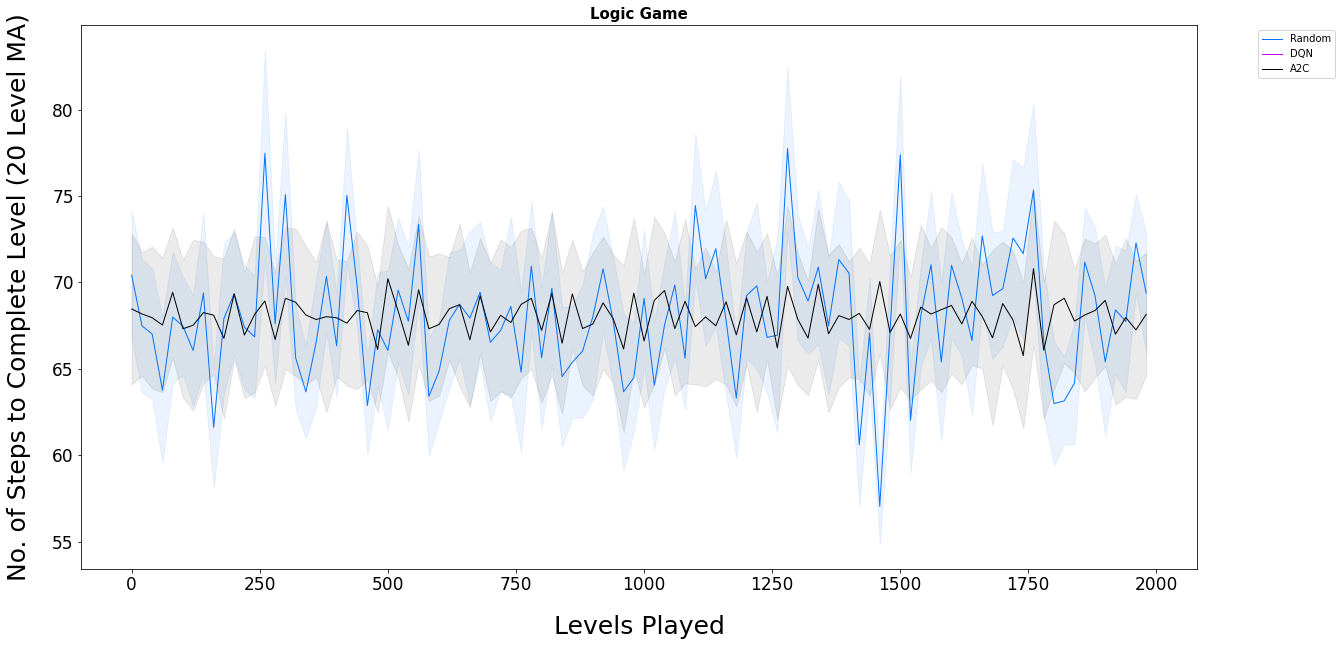

In [3]:
game_types = ["logic_game"]
agent_types = ["random", "dqn_training", "a2c_training",] # ,
y_lims = [250, 2000, 2000]
batch_size = 20
stats_dict, game_types, agent_types, y_lims, batch_size = get_performance(game_types, agent_types, y_lims, batch_size,)

# Get performance stats of extended game
game_types_ext = ["logic_extended_game"]
agent_types_ext = ["dqn_training", "trpo_training", "a2c_training", "acer_training"]
stats_dict_ext, game_types_ext, agent_types_ext, y_lims_ext, batch_size_ext = get_performance(game_types_ext,
                                                                                              agent_types_ext,
                                                                                              y_lims, batch_size)

plotter(stats_dict, game_types, agent_types, y_lims, batch_size, False)

#appended_stats = append_stats(stats_dict, stats_dict_ext, game_types, game_types_ext, agent_types)
#plotter(appended_stats, game_types, agent_types, y_lims, batch_size, True)

In [ ]:
## ----- Plot the number of steps the player takes before any agent moves from its starting location

# Plot non-moving action count of agent for each level
def plot_nm_ac(game_types, agent_types, batch_size=20):
    for i, game_type in enumerate(game_types):
        nm_ac = get_all_nm_ac(agent_types, game_type, batch_size)

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_ylim([0, 10])
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        ax.set_ylabel(ylabel="Action Count Until Movement ({} Level MA)".format(batch_size), labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)
        game_label_dict = {'logic_game': "Logic Game"}
        ax.set_title( game_label_dict[game_type], fontweight='bold', fontsize=15 )

        colors = ["#0373fc", "#d002f5", "#000000", "#fa0047", "#ff8903", "#03fc9d"]
        agent_label_dict = {'dqn_training': 'DQN', 'human':"Human", "self_class": "Self Class", "random": "Random",
                            'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training':'PPO2', "acer_training": "ACER"}
        for j, agent in enumerate(agent_types):


            if agent == 'human':
                xs = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]) + 1)]
                ax.plot( xs, np.append(nm_ac[agent + "_m"], nm_ac[agent + "_m"][1]), color=colors[j], linewidth=1, label=agent_label_dict[agent] )
                upper_curve = [nm_ac[agent + '_m'][i] + nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
                lower_curve = [nm_ac[agent + '_m'][i] - nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
                x = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]) + 1)]
                ax.fill_between( x, np.append(lower_curve, lower_curve[1]), np.append(upper_curve, upper_curve[1]), alpha=0.08, color=colors[j] )
            else:
                xs = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]))]
                ax.plot( xs, nm_ac[agent + "_m"], color=colors[j], linewidth=1, label=agent_label_dict[agent] )
                upper_curve = [nm_ac[agent + '_m'][i] + nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
                lower_curve = [nm_ac[agent + '_m'][i] - nm_ac[agent + '_se'][i] for i in range(len(nm_ac[agent + '_m']))]
                x = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]))]
                ax.fill_between( x, lower_curve, upper_curve, alpha=0.08, color=colors[j] )

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        
        fig.savefig('no_movement_action_count.pdf', format='pdf')

# # Get non-moving action count of agent for each level and each game as a dictionary
def get_all_nm_ac(agent_types, game_type, batch_size):

    stats = {}
    for agent in agent_types:
        stats[agent + "_m"], stats[agent + "_se"] = get_nm_ac(agent, game_type, batch_size)
        
    return stats

# Get non-moving action count of agent for each level
def get_nm_ac(agent_type, game_type, batch_size):

    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")



    # Iterate through each file
    # TODO: Divide each seed and get SEM

    all_seeds = []
    curr_seed = []
    seed = 0
    curr_file_count = 0
    for i, file in enumerate(sorted(files, key=os.path.getmtime)):
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]

        level_amt = 100
        action_count = [1] * level_amt

        # In each 100 levels:
        for level in range(level_amt):
            if len( self_locs[level] ) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range( action_amt ):
                if i == level_amt:
                    break

                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                x1 = self_locs[level][0][i + 1]
                y1 = self_locs[level][1][i + 1]

                if x == x1 and y == y1: # Still in the same position
                    action_count[level] = action_count[level] + 1
                else: # Position have changed
                    break

        curr_file_count += 1
        curr_seed.append(action_count)

        if curr_file_count == 20:
            all_seeds.append(curr_seed)
            curr_seed = []
            curr_file_count = 0
            seed += 1

    seed_average = []
    all_seeds = pd.DataFrame(all_seeds)
    for column in all_seeds:
        seed_average.append(np.mean(list(all_seeds[column]), axis=0))

    all_seeds = pd.DataFrame(seed_average).T

    seed_mean = np.array([all_seeds[column].groupby(all_seeds.index // batch_size).mean() for column in all_seeds]).reshape(int(all_seeds.shape[1] * 100 * 1/batch_size))
    s_sem = np.array([all_seeds[column].groupby(all_seeds.index // batch_size).sem() for column in all_seeds]).reshape(int(all_seeds.shape[1] * 100 * 1/batch_size))

    return seed_mean, s_sem

In [ ]:
agent_types = ["dqn_training", "trpo_training", "a2c_training", "acer_training", "random", "self_class"]
game_types = ["logic_game"]
plot_nm_ac(game_types, agent_types)